# Final Project - Yelp Location Classification
#### CSCI 3832 Natural Language Processing

Jupyter Notebook to load in the Yelp open dataset and classify reviews per state with LSTM. Runs validation scores and exports a copy of the model upon successful run.

The base LSTM is a modification of the homeworks in this class, with supporting functions added for features like plotting loss and the confusion matrix.

ChatGPT was used to help with error handling as well as with exporting the model weights to a file for use later, as noted at various points in the notebook.

In [1]:
# Necessary Imports

import os, random, sys, copy, re, sklearn, nltk, matplotlib
import torch, torch.nn as nn, numpy as np
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize
from torch.nn.utils.rnn import pack_padded_sequence
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from nltk.corpus import stopwords

In [2]:
print("Python:", sys.version)
print("Torch:", torch.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("NLTK:", nltk.__version__)
print("Matplotlib:", matplotlib.__version__)

Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Torch: 2.1.0+cu118
NumPy: 1.26.4
Pandas: 2.2.3
scikit-learn: 1.3.2
NLTK: 3.9.1
Matplotlib: 3.10.0


In [3]:
# Load the dataset
reviews_by_state = pd.read_csv(
    "C:/Users/danie/Downloads/reviews_with_locations.csv.gz",   # Adjust the path as necessary
    compression='gzip',
    usecols=["text", "state"]
)

# Preview the data
reviews_by_state.head()

,text,state
0,"If you decide to eat here, just be aware it is...",PA
1,This is the second time we tried turning point...,PA
2,The place is cute and the staff was very frien...,PA
3,We came on a Saturday morning after waiting a ...,PA
4,"Mediocre at best. The decor is very nice, and ...",PA


In [4]:
# Check the number of unique states in the dataset
reviews_by_state['state'].unique()

array(['PA', 'AZ', 'LA', 'CA', 'FL', 'IN', 'MO', 'TN', 'NV', 'NJ', 'IL',
       'ID', 'DE'], dtype=object)

In [ ]:
# Load the GloVe embeddings
# Modified version from homework 2
glove_file = 'glove.6B/glove.6B.50d.txt' # modify to appropriate path for your file system

embeddings_dict = {}

with open(glove_file, 'r', encoding='utf8') as f:
    for i, line in enumerate(f):
        line = line.strip().split(' ')
        word = line[0]
        embed = np.asarray(line[1:], "float")

        embeddings_dict[word] = embed


print('Loaded {} words from glove'.format(len(embeddings_dict)))

low = -1.0 / 3
high = 1.0 / 3
embedding_matrix = np.random.uniform(low=low, high=high, size=(len(embeddings_dict)+1, 50))

word2id = {}
for i, word in enumerate(embeddings_dict.keys(), 1):

    word2id[word] = i                                
    embedding_matrix[i] = embeddings_dict[word]      

word2id['<pad>'] = 0

# Add <unk> token
word2id['unk'] = len(word2id)
embedding_matrix = np.vstack([
    embedding_matrix,
    np.random.uniform(low=low, high=high, size=(50,))
])

Loaded 400000 words from glove


The cell below has a dictionary with keywords to use as flags which are added to the hidden layer on the LSTM. These are the top 10 largest or most popular cities in each state in the dataset, as well as 4 landmarks in that state. Also included is the name of each state. After running a few models and checking the reviews of the states with good F1 scores, we found that many of the properly classified states included city names, so these additions should theoretically enhance accuracy across all states.

In [6]:
# setup the dictionary for the state keywords
state_keywords = {
    "PA": [
        "Philadelphia", "Pittsburgh", "Allentown", "Erie", "Reading", "Scranton", "Bethlehem", "Lancaster", "Harrisburg", "York",
        "Liberty Bell", "Independence Hall", "Gettysburg", "Hersheypark", "Pennsylvania"
    ],
    "AZ": [
        "Phoenix", "Tucson", "Mesa", "Chandler", "Scottsdale", "Glendale", "Gilbert", "Tempe", "Peoria", "Surprise",
        "Grand Canyon", "Sedona", "Hoover Dam", "Saguaro National Park", "Arizona"
    ],
    "LA": [
        "New Orleans", "Baton Rouge", "Shreveport", "Lafayette", "Lake Charles", "Kenner", "Bossier City", "Monroe", "Alexandria", "Houma",
        "French Quarter", "Mardi Gras", "Bayou", "Bourbon Street", "Louisiana"
    ],
    "CA": [
        "Los Angeles", "San Diego", "San Jose", "San Francisco", "Fresno", "Sacramento", "Long Beach", "Oakland", "Bakersfield", "Anaheim",
        "Hollywood", "Yosemite", "Golden Gate Bridge", "Disneyland", "California"
    ],
    "FL": [
        "Miami", "Tampa", "Orlando", "Jacksonville", "St. Petersburg", "Hialeah", "Tallahassee", "Fort Lauderdale", "Cape Coral", "Pembroke Pines",
        "Everglades", "South Beach", "Key West", "Universal Studios", "Florida"
    ],
    "IN": [
        "Indianapolis", "Fort Wayne", "Evansville", "South Bend", "Carmel", "Fishers", "Bloomington", "Hammond", "Gary", "Muncie",
        "Notre Dame", "Indy 500", "Lucas Oil Stadium", "Indiana Dunes", "Indiana"
    ],
    "MO": [
        "Kansas City", "St. Louis", "Springfield", "Columbia", "Independence", "Lee's Summit", "O'Fallon", "St. Joseph", "St. Charles", "Blue Springs",
        "Gateway Arch", "Lake of the Ozarks", "Silver Dollar City", "Branson Strip", "Missouri"
    ],
    "TN": [
        "Nashville", "Memphis", "Knoxville", "Chattanooga", "Clarksville", "Murfreesboro", "Franklin", "Jackson", "Johnson City", "Bartlett",
        "Graceland", "Grand Ole Opry", "Dollywood", "Beale Street", "Tennessee"
    ],
    "NV": [
        "Las Vegas", "Henderson", "Reno", "North Las Vegas", "Sparks", "Carson City", "Elko", "Mesquite", "Boulder City", "Fallon",
        "Strip", "Fremont Street", "Hoover Dam", "Lake Tahoe", "Nevada"
    ],
    "NJ": [
        "Newark", "Jersey City", "Paterson", "Elizabeth", "Edison", "Trenton", "Camden", "Clifton", "Passaic", "Bayonne",
        "Atlantic City Boardwalk", "Liberty State Park", "Six Flags", "Cape May Lighthouse", "New Jersey"
    ],
    "IL": [
        "Chicago", "Aurora", "Naperville", "Joliet", "Rockford", "Springfield", "Elgin", "Peoria", "Champaign", "Waukegan",
        "Millennium Park", "Willis Tower", "Navy Pier", "Wrigley Field", "Illinois"
    ],
    "ID": [
        "Boise", "Meridian", "Nampa", "Idaho Falls", "Pocatello", "Caldwell", "Twin Falls", "Lewiston", "Coeur d'Alene", "Moscow",
        "Shoshone Falls", "Sun Valley", "Snake River Canyon", "Sawtooth Mountains", "Idaho"
    ],
    "DE": [
        "Wilmington", "Dover", "Newark", "Middletown", "Smyrna", "Milford", "Seaford", "Georgetown", "Elsmere", "New Castle",
        "Rehoboth Beach", "Bethany Beach", "Cape Henlopen", "Hagley Museum", "Delaware"
    ]
}


In [7]:
# Create a reverse mapping for state keywords
state_list = list(state_keywords.keys())

def get_state_flags(text):
    flags = [0] * len(state_keywords)
    if not isinstance(text, str):
        return flags

    lowered = text.lower()
    for idx, (state, keywords) in enumerate(state_keywords.items()):
        if any(kw.lower() in lowered for kw in keywords):
            flags[idx] = 1
    return flags

# use stop words from nltk
stop_words = set(stopwords.words('english'))

In [ ]:
# Define the Dataset class
# this will create a dataset for the reviews by state and tokenize the text
class YelpReviewByStateDataset(Dataset):
    def __init__(self, csv_path=None, df=None, word2id=None, max_length=256, data_limit=None, label_set=None, tokenizer=True):
        self.word2id = word2id
        self.max_length = max_length

        # Load data
        if df is not None:
            self.df = df.copy()
        else:
            self.df = pd.read_csv(csv_path, compression='gzip', usecols=['text', 'state'])

        # Apply data limit regardless of source
        if data_limit:
            self.df = self.df.sample(n=data_limit, random_state=50).reset_index(drop=True)

        self.texts = self.df["text"].tolist()
        self.labels = self.df["state"].tolist()

        # Define label mappings
        if label_set is None:
            self.label_set = sorted(set(self.labels))
        else:
            self.label_set = label_set

        self.label2id = {label: idx for idx, label in enumerate(self.label_set)}
        self.id2label = {idx: label for label, idx in self.label2id.items()}

        print(f"..Processing {len(self.texts)} reviews for keyword flags")
        self.state_flags = []
        for i, txt in enumerate(self.texts):
            if i % 250000 == 0 and i > 0:
                print(f"...processed {i}")
            self.state_flags.append(get_state_flags(txt))

        # Process tokenized data
        self.data = self.tokenize(self.texts, self.labels, tokenizer)

    def tokenize(self, texts, labels, tokenizer, remove_stopwords=True):
        print(f"Starting tokenization of {len(texts)} texts...")
        examples = []
        for i, (text, label) in enumerate(tqdm(zip(texts, labels), total=len(texts), desc="Tokenizing examples")):
            if tokenizer:
                tokens = word_tokenize(str(text).lower())
            else:
                tokens = str(text).lower().split()

            if remove_stopwords:
                tokens = [tok for tok in tokens if tok not in stop_words]

            ids = [self.word2id.get(tok, self.word2id.get('unk', 0)) for tok in tokens]

            if len(ids) > self.max_length:
                ids = ids[:self.max_length]

            length = len(ids)

            if length == 0:
                continue

            if len(ids) < self.max_length:
                ids += [self.word2id.get('<pad>', 0)] * (self.max_length - len(ids))

            input_tensor = torch.tensor(ids)
            length_tensor = torch.tensor(length)

            # Convert state flags to tensor
            state_flag_tensor = torch.tensor(self.state_flags[i], dtype=torch.float32)

            examples.append(((input_tensor, length_tensor, state_flag_tensor), self.label2id[label]))
        
        return examples

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

### Create Datasets

In [ ]:
# function to create a DataFrame sampler
def create_df_sampler(df=None, replacement=False, n_samples=50_000):

    sampled_dfs = [
        group.sample(n=n_samples, replace=replacement)
        for _, group in reviews_by_state.groupby('state')
    ]

    reviews_by_state_sampled = pd.concat(sampled_dfs).reset_index(drop=True)

    return reviews_by_state_sampled

In [ ]:
# function to prepare the datasets for training and validation
def prepare_yelp_datasets(
    reviews_df,
    word2id,
    test_size=0.2,
    random_state=50,
    tokenized=False
):

    # Split into train and validation
    train_df, valid_df = train_test_split(
        reviews_df,
        test_size=test_size,
        random_state=random_state,
        stratify=reviews_df['state']
    )

    # Consistent label set
    label_set = sorted(train_df['state'].unique())
    print("Creating train dataset...")

    train_dataset = YelpReviewByStateDataset(
        df=train_df,
        word2id=word2id,
        label_set=label_set,
        tokenizer=tokenized
    )
    valid_dataset = YelpReviewByStateDataset(
        df=valid_df,
        word2id=word2id,
        label_set=label_set,
        tokenizer=tokenized
    )

    return train_dataset, valid_dataset, label_set

In [11]:
# predict function to evaluate the model
def predict(model, valid_dataloader, device='cpu'):
    model.eval()
    total_correct = 0
    total_examples = len(valid_dataloader.dataset)

    with torch.no_grad():
        for (x, x_lengths, state_flags), y in valid_dataloader:
            x = x.to(device)
            x_lengths = x_lengths.to(device)
            y = y.to(device)

            state_flags = state_flags.to(device)
            logits = model(x, x_lengths, state_flags)

            predictions = torch.argmax(logits, dim=1)
            total_correct += (predictions == y).sum().item()

    accuracy = total_correct / total_examples
    print('Accuracy: {:.2f}%'.format(accuracy * 100))
    return accuracy

In [ ]:
# training function for the LSTM model
# calculates training and validation loss and accuracy
def train_lstm_classification(
    model,
    train_dataset,
    valid_dataset,
    epochs=10,
    batch_size=32,
    learning_rate=0.001,
    print_frequency=25,
    device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128)

    best_accuracy = 0.0
    best_model_sd = None
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print(f"\n### Epoch {epoch + 1} ###")
        model.train()
        avg_loss = 0

        # ChatGPT helped with errors in this loop
        for step, ((x, x_lengths, state_flags), y) in enumerate(train_loader):
            x = x.to(device)
            x_lengths = x_lengths.cpu()  # keep on CPU for pack_padded_sequence
            state_flags = state_flags.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            output = model(x, x_lengths, state_flags)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            if (step + 1) % print_frequency == 0:
                avg_val = avg_loss / print_frequency
                print(f'epoch: {epoch} batch: {step} loss: {avg_loss / print_frequency:.4f}')
                train_losses.append(avg_val)
                avg_loss = 0

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for (x, x_lengths, state_flags), y in valid_loader:
                x = x.to(device)
                x_lengths = x_lengths.cpu()
                state_flags = state_flags.to(device)
                y = y.to(device)

                output = model(x, x_lengths, state_flags)
                loss = criterion(output, y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(valid_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")

        acc = predict(model, valid_loader, device=device)
        if acc > best_accuracy:
            best_accuracy = acc
            best_model_sd = copy.deepcopy(model.state_dict())

    return model.state_dict(), best_model_sd, train_losses, val_losses


In [14]:
# Define the LSTM model
# this model will use the embedding matrix created from the GloVe embeddings and the LSTM layers to classify the reviews
class LSTMModel(nn.Module):
    def __init__(self, embedding_matrix, num_classes, lstm_hidden_size=50, num_lstm_layers=1, bidirectional=True, state_flag_size=13):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.lstm = nn.LSTM(
            input_size=embedding_matrix.shape[1],
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            bidirectional=bidirectional,
            batch_first=True
        )

        self.hidden_1 = nn.Linear(lstm_hidden_size * 2 + state_flag_size, lstm_hidden_size)
        self.hidden_2 = nn.Linear(lstm_hidden_size, num_classes)
        self.num_directions = 2 if bidirectional else 1
        self.relu = nn.ReLU()

    def forward(self, input_batch, input_lengths, state_flags=None):
        embedded_input = self.embedding(input_batch)
        packed_input = nn.utils.rnn.pack_padded_sequence(
            embedded_input, input_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_output, (hn, cn) = self.lstm(packed_input)

        hn_view = hn.view(
            self.lstm.num_layers, self.num_directions, input_batch.shape[0], self.lstm.hidden_size
        )
        hn_view_last_layer = hn_view[-1]
        hn_cat = torch.cat([hn_view_last_layer[-2], hn_view_last_layer[-1]], dim=1)

        # If state_flags is provided, concatenate with LSTM hidden output
        if state_flags is not None:
            hn_cat = torch.cat([hn_cat, state_flags], dim=1)

        hid = self.relu(self.hidden_1(hn_cat))
        return self.hidden_2(hid)


In [15]:
# Function to visualize the training and validation loss
def evaluate_model(model, dataset, device):
    model.eval()
    y_true = []
    y_pred = []

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)

    with torch.no_grad():
        for (x, x_lengths, state_flags), y in dataloader:
            x = x.to(device)
            x_lengths = x_lengths.to(device)
            y = y.to(device)

            state_flags = state_flags.to(device)
            logits = model(x, x_lengths, state_flags)


            preds = torch.argmax(logits, dim=1)
            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    report = classification_report(y_true, y_pred, target_names=dataset.label_set, zero_division=0)
    print(report)
    return report


In [16]:
# Function to plot the confusion matrix
def plot_confusion_matrix(model, dataset, device):
    model.eval()
    y_true = []
    y_pred = []

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)

    with torch.no_grad():
        for (x, x_lengths, state_flags), y in dataloader:
            x = x.to(device)
            x_lengths = x_lengths.to(device)
            y = y.to(device)

            state_flags = state_flags.to(device)
            logits = model(x, x_lengths, state_flags)

            preds = torch.argmax(logits, dim=1)
            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    cm = confusion_matrix(y_true, y_pred, labels=range(len(dataset.label_set)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.label_set)
    disp.plot(cmap='viridis', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    return cm


In [ ]:
# Function to train and save the model
# automatically saves the model after training
def train_and_save_model(training_data, run_name="model", tokenized=False, batch_size=128, epochs=4):    
    train_dataset, valid_dataset, label_set = prepare_yelp_datasets(
        reviews_df=training_data,
        word2id=word2id,
        tokenized=tokenized
    )

    print(len(train_dataset), "train samples")
    print(len(valid_dataset), "validation samples")
    print(train_dataset[0])  # (tensor, label_id)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = LSTMModel(embedding_matrix, num_classes=len(train_dataset.label_set))
    model_sd, best_model_sd, train_losses, val_losses = train_lstm_classification(
        model, train_dataset, valid_dataset, batch_size=batch_size, epochs=epochs, device=device
    )

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss", color="blue")
    plt.title("Training Loss Over Time")
    plt.xlabel("Logging Step")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    # Plot validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(val_losses, label="Validation Loss", color="orange", linestyle="--")
    plt.title("Validation Loss Per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


    report = evaluate_model(model, valid_dataset, device=device)
    matrix = plot_confusion_matrix(model, valid_dataset, device=device)

    model_filename = f"{run_name}_tok{tokenized}_ep{epochs}.pt"

    # ChatGPT helped with exporting the model
    torch.save(model.state_dict(), model_filename)
    print(f"Model saved to {model_filename}")

    return model, report, matrix

### Create test set and run the model

Creating train dataset...
..Processing 52000 reviews for keyword flags
Starting tokenization of 52000 texts...


Tokenizing examples:   0%|          | 0/52000 [00:00<?, ?it/s]

..Processing 13000 reviews for keyword flags
Starting tokenization of 13000 texts...


Tokenizing examples:   0%|          | 0/13000 [00:00<?, ?it/s]

52000 train samples
13000 validation samples
((tensor([   742,    968,   1628,   6851,    589,    979,    182,  28288,      2,
         71155,    846,      3,    566,   2671,   2147,    589,    220,    848,
           327,    185,   1739,    205,  60861,      3,    242,   4260,   9929,
          1041,      3,    248,   1335,    600,    663,   8173,      2,   1437,
          1950,    264,   1923,   1178,      3,   1299,   4299,  31920,  21374,
         50511,    317,      2,   3021,   3021,  18961,      2,   7636,  33376,
          3671,  10504,  55636,    317,      3,    366,   1976,    806,    806,
           806,    806,    461,  33376,  55636,    317,   3268,    333,  20891,
             2,  11347, 224206,   1034,    566,      3,   5204,      2,  55636,
           317,    563,      2,  30356,   4167,   1034,    566,     71,   4375,
           220,      3,     53,      2,   1567,   7488,  21374,   7466,    109,
            10,    317,    816,      2,   1107,    118,   4526,    317,  

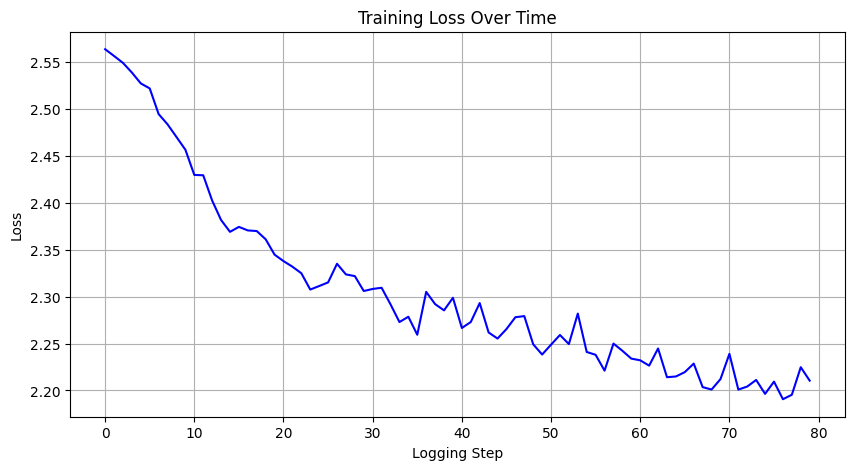

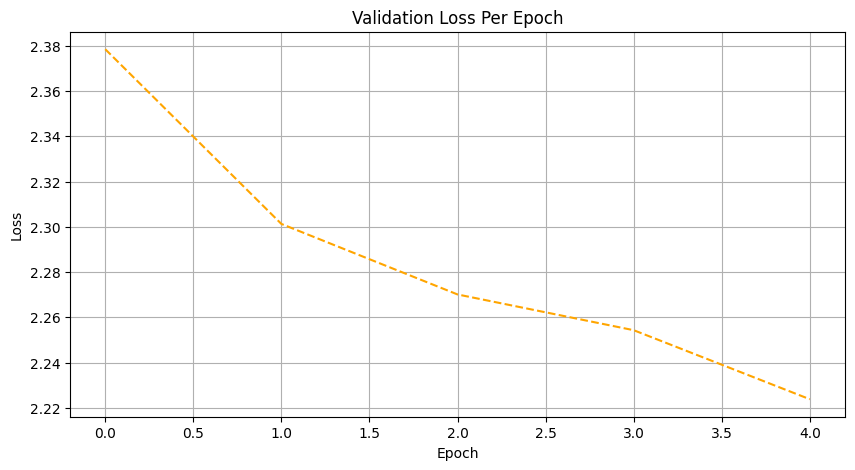

              precision    recall  f1-score   support

          AZ       0.20      0.27      0.23      1000
          CA       0.27      0.37      0.31      1000
          DE       0.16      0.25      0.20      1000
          FL       0.22      0.17      0.19      1000
          ID       0.40      0.22      0.28      1000
          IL       0.17      0.10      0.13      1000
          IN       0.25      0.19      0.21      1000
          LA       0.31      0.49      0.38      1000
          MO       0.31      0.10      0.16      1000
          NJ       0.13      0.19      0.15      1000
          NV       0.27      0.30      0.28      1000
          PA       0.16      0.19      0.17      1000
          TN       0.65      0.23      0.34      1000

    accuracy                           0.24     13000
   macro avg       0.27      0.24      0.23     13000
weighted avg       0.27      0.24      0.23     13000



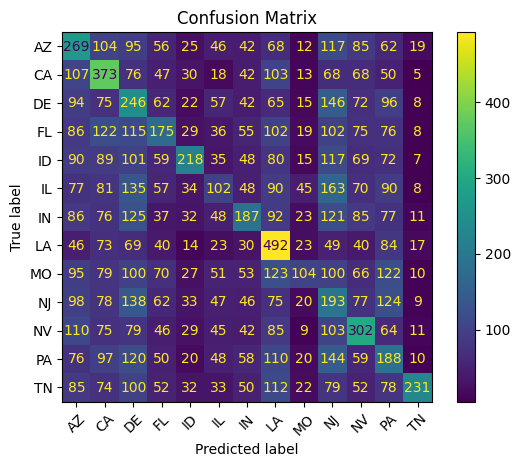

Model saved to lstm_5000_flags_tokTrue_ep5.pt


In [26]:
# Adjust parameters for different runs
reviews_sampled = create_df_sampler(
    reviews_by_state, 
    n_samples=5000, 
    replacement=False
)

# create the model and train it on the samples
model, report, matrix = train_and_save_model(
    training_data=reviews_sampled,
    run_name="lstm_5000_flags",     # name of the model weights to save
    tokenized=True,
    batch_size=128,
    epochs=5
)

Creating train dataset...
..Processing 1040000 reviews for keyword flags
...processed 250000
...processed 500000
...processed 750000
...processed 1000000
Starting tokenization of 1040000 texts...


Tokenizing examples:   0%|          | 0/1040000 [00:00<?, ?it/s]

..Processing 260000 reviews for keyword flags
...processed 250000
Starting tokenization of 260000 texts...


Tokenizing examples:   0%|          | 0/260000 [00:00<?, ?it/s]

1039999 train samples
259999 validation samples
((tensor([ 23253, 400001,   1544,   2473,    339,    408, 400001,    160,    342,
           195,    409,   1123,    416, 400001,   1544,    637, 400001,   2634,
        400001,  69648,  10186,    416,  39301,     12,  10137,    109,   5034,
           590,   1248,    902,  10186, 400001,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0

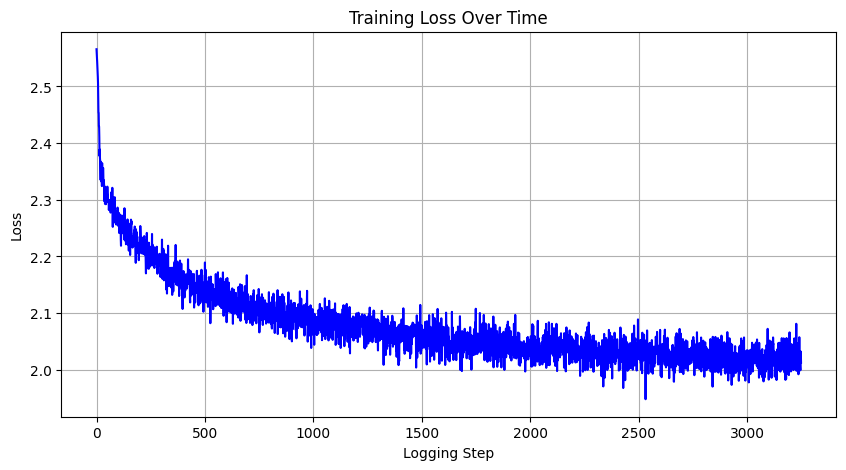

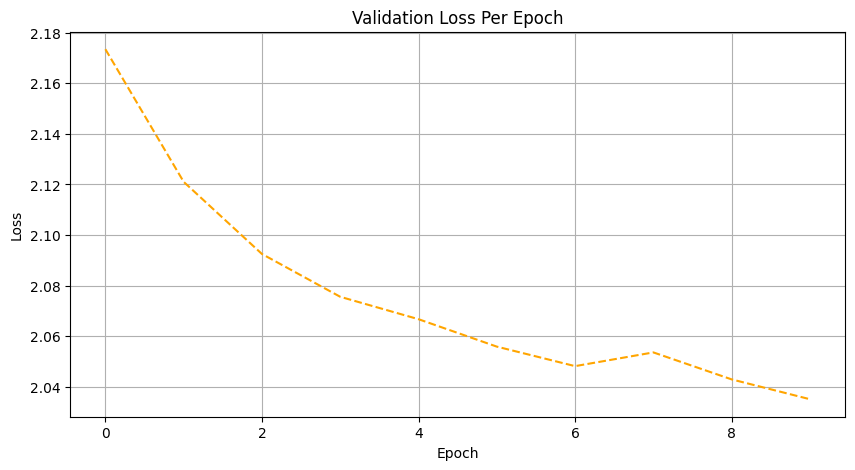

              precision    recall  f1-score   support

          AZ       0.29      0.29      0.29     20000
          CA       0.33      0.46      0.39     20000
          DE       0.27      0.29      0.28     20000
          FL       0.44      0.22      0.29     20000
          ID       0.28      0.33      0.30     20000
          IL       0.20      0.44      0.27     20000
          IN       0.43      0.23      0.30     20000
          LA       0.48      0.50      0.49     20000
          MO       0.42      0.20      0.27     20000
          NJ       0.25      0.27      0.26     20000
          NV       0.38      0.30      0.34     20000
          PA       0.31      0.22      0.26     20000
          TN       0.37      0.35      0.36     19999

    accuracy                           0.32    259999
   macro avg       0.34      0.32      0.31    259999
weighted avg       0.34      0.32      0.31    259999



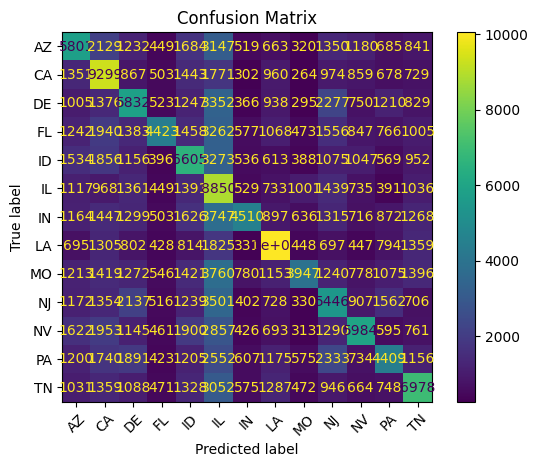

Model saved to lstm_10000_flags_10_epochs_tokFalse_ep10.pt


In [29]:
# Adjust parameters for different runs
reviews_sampled = create_df_sampler(
    reviews_by_state, 
    n_samples=100000, 
    replacement=True
)

# create the model and train it on the samples
model, report, matrix = train_and_save_model(
    training_data=reviews_sampled,
    run_name="lstm_10000_flags",     # name of the model weights to save
    tokenized=False,
    batch_size=128,
    epochs=10
)

Creating train dataset...
..Processing 52000 reviews for keyword flags
Starting tokenization of 52000 texts...


Tokenizing examples:   0%|          | 0/52000 [00:00<?, ?it/s]

..Processing 13000 reviews for keyword flags
Starting tokenization of 13000 texts...


Tokenizing examples:   0%|          | 0/13000 [00:00<?, ?it/s]

52000 train samples
13000 validation samples
((tensor([   742,    968,   1628,   6851,    589,    979,    182, 400001,  71155,
           846, 400001,    566,   2671,   2147,    589,    220,    848,    327,
           185,   1739,    205, 400001,    242,   4260,   9929, 400001,    248,
          1335,    600,    663, 400001,   1437,   1950,    264,   1923, 400001,
          1299,   4299,  31920,  21374,  50511, 400001,   3021,   3021, 400001,
          7636,  33376,   3671,  10504,  55636, 400001,    366, 400001,    461,
         33376,  55636,    317,   3268,    333,  20891, 400001,  11347, 224206,
          1034, 400001, 400001,  55636,    317, 400001,  30356,   4167,   1034,
           566,   4375,    220, 400001, 400001,   1567,   7488,  21374,   7466,
           109,    317, 400001,   1107,    118,   4526, 400001,   4299,  13650,
         21374,  20891, 400001, 400001,  13577, 400001, 400001,   1175,   8264,
         19645,    589, 400001,     55,    118,    327,    138,    842,  

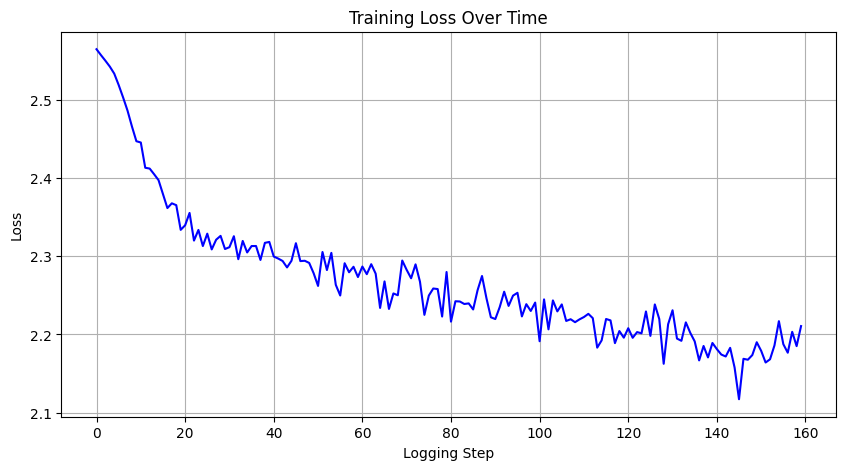

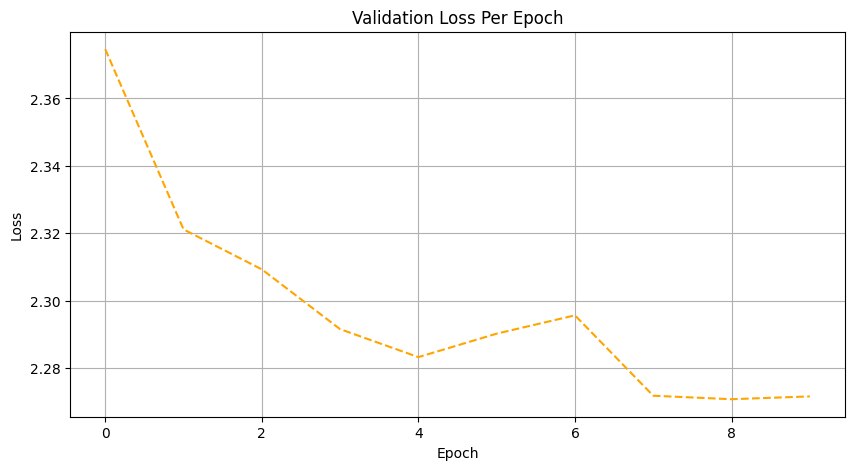

              precision    recall  f1-score   support

          AZ       0.26      0.20      0.23      1000
          CA       0.28      0.32      0.29      1000
          DE       0.28      0.15      0.20      1000
          FL       0.21      0.17      0.19      1000
          ID       0.32      0.24      0.28      1000
          IL       0.15      0.23      0.18      1000
          IN       0.20      0.17      0.18      1000
          LA       0.33      0.48      0.39      1000
          MO       0.22      0.14      0.17      1000
          NJ       0.15      0.14      0.14      1000
          NV       0.21      0.34      0.26      1000
          PA       0.17      0.17      0.17      1000
          TN       0.32      0.29      0.31      1000

    accuracy                           0.23     13000
   macro avg       0.24      0.23      0.23     13000
weighted avg       0.24      0.23      0.23     13000



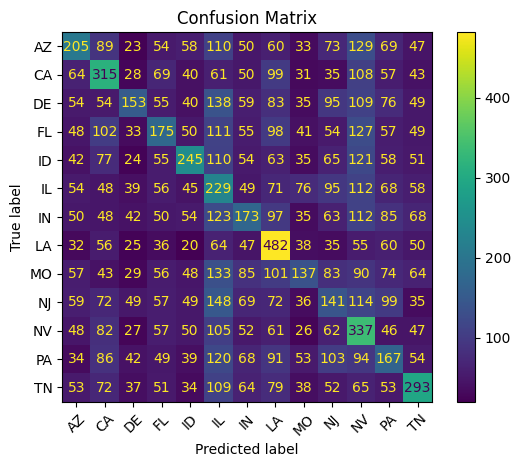

Model saved to lstm_5000_flags_10_epochs_tokFalse_ep10.pt


In [ ]:
# Adjust parameters for different runs
reviews_sampled = create_df_sampler(
    reviews_by_state, 
    n_samples=5000, 
    replacement=False
)

# create the model and train it on the samples
model, report, matrix = train_and_save_model(
    training_data=reviews_sampled,
    run_name="lstm_5000_flags",     # name of the model weights to save
    tokenized=False,
    batch_size=128,
    epochs=10
)

Creating train dataset...
..Processing 520000 reviews for keyword flags
...processed 250000
...processed 500000
Starting tokenization of 520000 texts...


Tokenizing examples:   0%|          | 0/520000 [00:00<?, ?it/s]

..Processing 130000 reviews for keyword flags
Starting tokenization of 130000 texts...


Tokenizing examples:   0%|          | 0/130000 [00:00<?, ?it/s]

520000 train samples
130000 validation samples
((tensor([   271, 400001,    566, 400001,  18086,    895,   9458,   1882, 400001,
           531,   8264,   3690, 400001,   5021,    242,   1136,   2109, 400001,
        400001, 400001,  18015,   1923, 400001,   1299,    358,  55475, 400001,
         89869, 400001,   4338,  41722,  22867, 400001,   2126,    566,    978,
           589,    117,    243, 400001,   5282,    456,     56,   1570,    251,
        400001, 400001,    566,    646,    170,   5857, 400001, 400001,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,

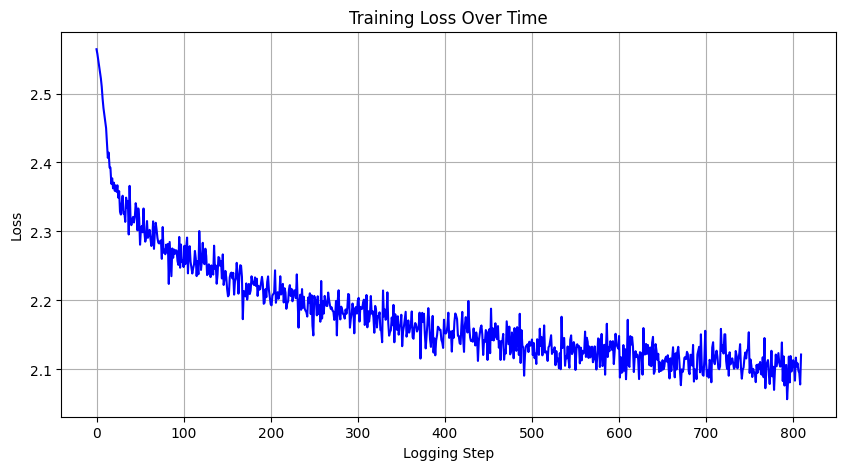

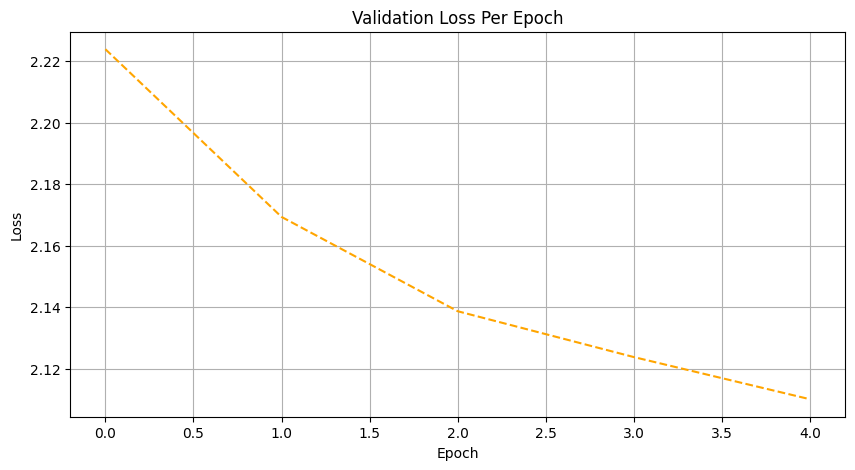

              precision    recall  f1-score   support

          AZ       0.32      0.25      0.28     10000
          CA       0.35      0.39      0.37     10000
          DE       0.30      0.21      0.25     10000
          FL       0.38      0.22      0.28     10000
          ID       0.29      0.29      0.29     10000
          IL       0.18      0.29      0.22     10000
          IN       0.23      0.25      0.24     10000
          LA       0.43      0.52      0.47     10000
          MO       0.35      0.17      0.23     10000
          NJ       0.25      0.20      0.22     10000
          NV       0.25      0.36      0.30     10000
          PA       0.21      0.30      0.24     10000
          TN       0.37      0.30      0.33     10000

    accuracy                           0.29    130000
   macro avg       0.30      0.29      0.29    130000
weighted avg       0.30      0.29      0.29    130000



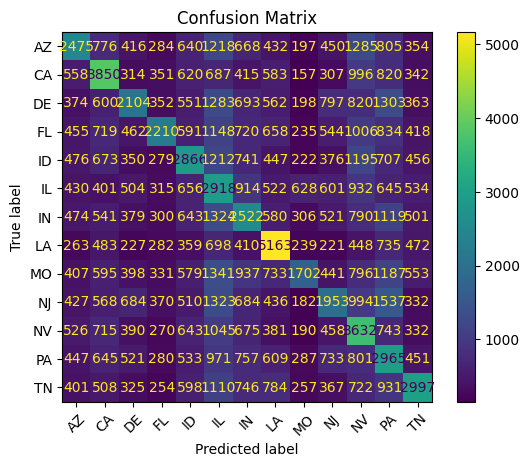

Model saved to lstm_5000_flags_tokFalse_ep5.pt


In [25]:
# Adjust parameters for different runs
reviews_sampled = create_df_sampler(
    reviews_by_state, 
    n_samples=50000, 
    replacement=False
)

# create the model and train it on the samples
model, report, matrix = train_and_save_model(
    training_data=reviews_sampled,
    run_name="lstm_50000_flags",     # name of the model weights to save
    tokenized=False,
    batch_size=128,
    epochs=5
)